In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


ACTN2
1
1
ALPK3
2
21
FLNC
6
11
MYBPC3
6
36
MYH6
0
3
MYH7
13
12
PTPN11


/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column sex have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['is_hcm'].astype(bool)
>>> print(df.loc[events, 'sex'].var())
>>> print(df.loc[~events, 'sex'].var())

A very low variance means that the column sex completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.499. This may imply non-unique solutions to the maximum likelihood. Perhaps ther

4
1
TNNI3


/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column age has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column age has high sample correlation with the duration colum

1
1


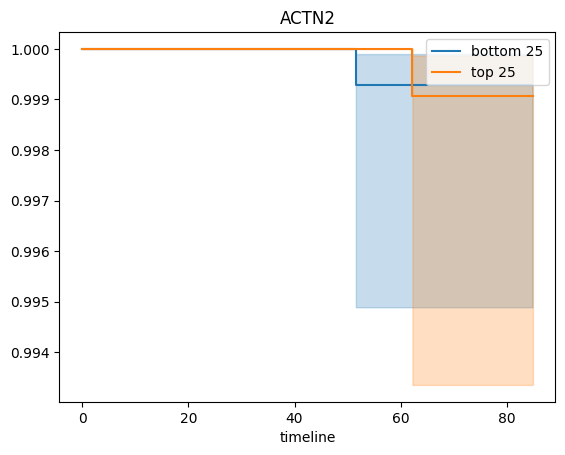

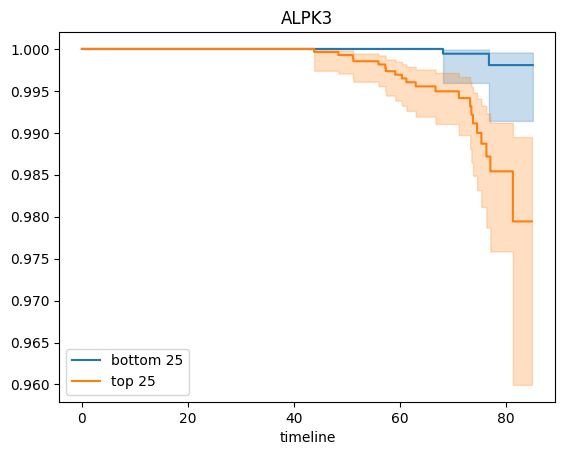

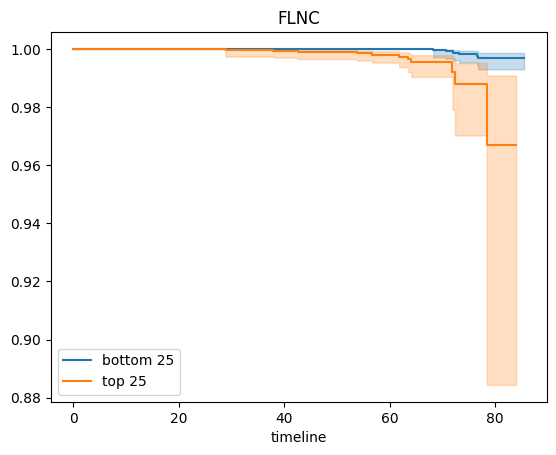

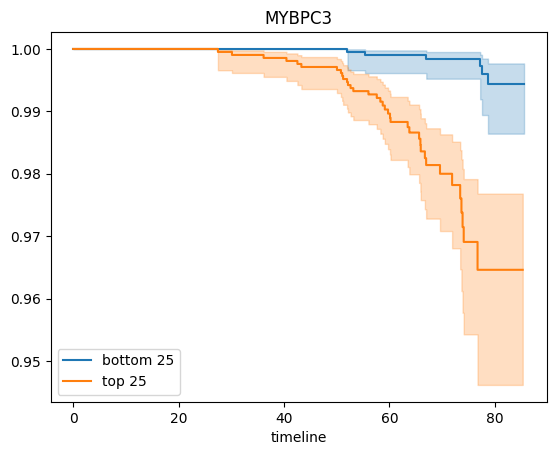

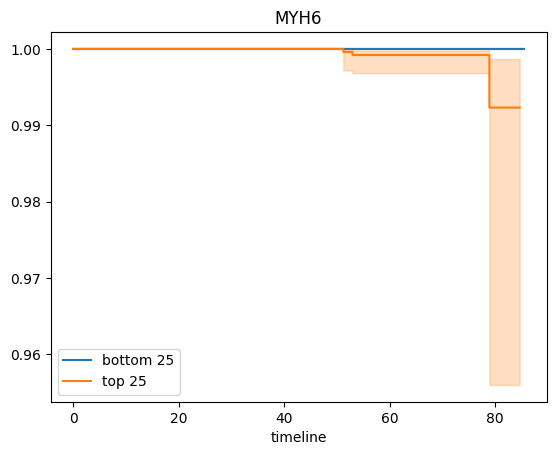

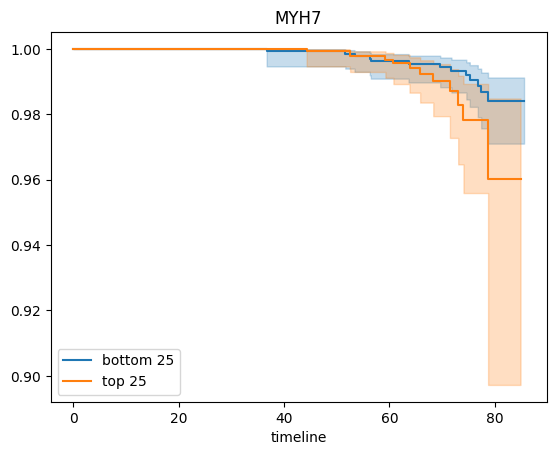

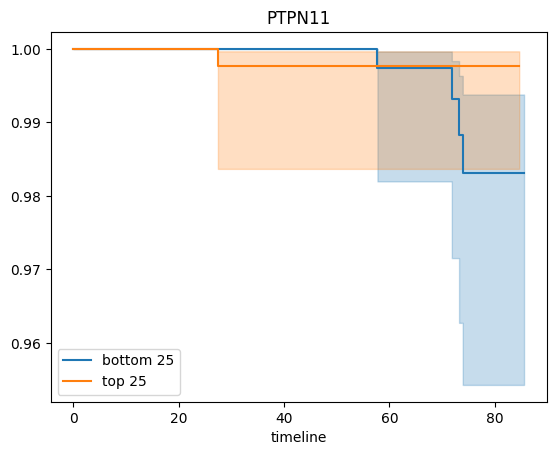

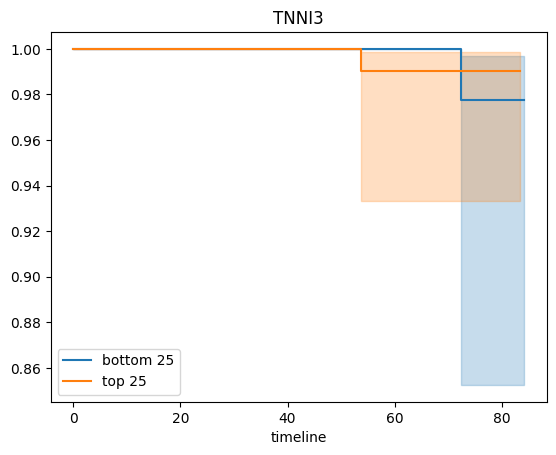

<Figure size 640x480 with 0 Axes>

In [2]:
genes = ["ACTN2", "ALPK3", "FLNC", "MYBPC3", "MYH6", "MYH7", "PTPN11", "TNNI3"]
p_vals = {}

def cross_val(gene):
    cph = CoxPHFitter()

    # read in file
    file_name=gene+'.csv'
    phenotypic_data = pd.read_csv("/Users/uriel/Downloads/work_temp/cross_val_lifelines/"+file_name, dtype={
            'is_family_hist':'boolean',
            'is_hcm':'boolean'
            })

    
    file_name=gene+'.csv'
    variant_data = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_files/"+file_name)
    variant_data = variant_data[['Name']]
    variant_data['var_index'] = variant_data.index
    phenotypic_data = variant_data.merge(phenotypic_data, how="outer")
    phenotypic_data.set_index("var_index")



    phenotypic_data = phenotypic_data.drop(["Name", "death_age", "Unnamed: 0", "birth_date"], axis = 1)
    phenotypic_data.loc[phenotypic_data['deleterious'] == 1, 'am_pathogenicity'] = 1



    phenotypic_data = phenotypic_data[(phenotypic_data['deleterious'] == True) | (phenotypic_data['missense_variant'] == True)]
                


    phenotypic_data = phenotypic_data.drop(['principal_component_2','principal_component_3', 'principal_component_5', 'principal_component_6', 'principal_component_7', 'principal_component_8', 'principal_component_9', 'principal_component_10', 'deleterious', 'synonymous_variant', 'missense_variant'], axis = 1)


    kf = KFold(n_splits=5, shuffle=True, random_state=2)
    testing_set = []

    
    # cross validation: split up phenotypic data file based on variant file index
    for train_idx, test_idx in kf.split(variant_data):
            train = phenotypic_data[phenotypic_data['var_index'].isin(train_idx)]
            test = phenotypic_data[phenotypic_data['var_index'].isin(test_idx)]

            train = train.drop(['var_index'], axis=1)
            test = test.drop(['var_index'], axis=1)

            # fit CPH and add hazard scores
            cph.fit(train, duration_col="duration", event_col="is_hcm", fit_options = {"step_size":0.1})
            hazard_scores_fold = cph.predict_partial_hazard(test)
            test['hazard'] = hazard_scores_fold
            testing_set.append(test)

    phenotypic_data = pd.concat([df for idx, df in enumerate(testing_set)])

    # check that you're matching up hazard scores properly - maybe make a new dataframe?

    percentiles = np.percentile(phenotypic_data['hazard'], [25, 75])
    bottom_25 = phenotypic_data[phenotypic_data['hazard'] < percentiles[0]]
    top_25 = phenotypic_data[phenotypic_data['hazard'] > percentiles[1]]
    print(len(bottom_25[bottom_25["is_hcm"]== 1]))
    print(len(top_25[top_25["is_hcm"] == 1]))
    bottom_25 = bottom_25.assign(is_highest=0)
    top_25 = top_25.assign(is_highest=1)
    df = pd.concat([bottom_25, top_25], keys=['low', 'high'])[['is_hcm', 'duration', 'is_highest']]

    #cph = CoxPHFitter()
    #cph.fit(df, duration_col="duration", event_col="is_hcm", fit_options = {"step_size":0.001})
    #p_vals.update({gene:cph.summary.loc["is_highest","p"]})

    bottom_25['is_hcm'] = bottom_25['is_hcm'].astype('float')
    top_25['is_hcm'] = top_25['is_hcm'].astype('float')

    kmf_lowest_25_variant = KaplanMeierFitter()
    kmf_lowest_25_variant.fit(durations=bottom_25['duration'], event_observed=bottom_25['is_hcm'], label = 'bottom 25')
    kmf_lowest_25_variant.plot_survival_function()


    kmf_highest_25_variant = KaplanMeierFitter()
    kmf_highest_25_variant.fit(durations=top_25['duration'], event_observed=top_25['is_hcm'], label = 'top 25')
    kmf_highest_25_variant.plot_survival_function()


    plt.title(gene)
    plt.figure()







for gene in genes:
    print(gene)
    cross_val(gene)



In [ ]:
p_adjusted = multipletests(list(p_vals.values()), alpha=0.05, method='bonferroni')
updated_dict = {key: new_p_val for key, new_p_val in zip(p_vals.keys(), p_adjusted[1])}
print("P-values: ", updated_dict)